# House Price Prediction Using Linear Regression

### Submitted By:
Arunava Mukherjee (24BM6JP11)

Bhavya Aarya (24BM6JP14)

Harshal Bhagwat Ugalmugle (24BM6JP20)

Pranjal Chakraborty (24BM6JP41)


## Importing Modules

In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")

## Reading .csv File

In [383]:
df=pd.read_csv("/Users/sora/PycharmProjects/Notebooks/House Price Prediction/house-prices-advanced-regression-techniques/train.csv")
df.drop('Id',axis=1,inplace=True)

In [384]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [385]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Performing Missing Value Imputation

1. We will remove columns which have over 40% missing values
2. We will create a dataset which only contains columns with no missingness
3. We will one-by-one attach a missing numerical column and under MAR assumption impute using Linear Regression
4. We will do this for all the numerical columns one-by-one and then create a dataset which has original columns as well as imputed numerical columns
5. We will now do the same procedure for categorical columns where we will attach each missing categorical columns one-by-one and impute using Logistic Regression
6. We will finally obtain a dataset with all columns having no missingness.

*We will use 10 Fold CV to get the RMSE and Accuracy for each imputed column on the data that is present
After which we will train on the entire available data to get the model for imputation. This is done to know whether
acceptable imputation is occuring or not. (e.g. if 10 Fold CV accuracy if 50% then there is no point of imputation.)

In [386]:
cols_NA=[]
for i in df.columns:
  print('Column Name:',i)
  print('------------------------------------')
  print('Unique Values:',df[i].unique())
  print('Null Values:',df[i].isnull().sum())
  print('------------------------------------\n\n')
  print('------------------------------------')
  if df[i].isnull().sum()!=0:
    cols_NA.append(i)

Column Name: MSSubClass
------------------------------------
Unique Values: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Null Values: 0
------------------------------------


------------------------------------
Column Name: MSZoning
------------------------------------
Unique Values: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Null Values: 0
------------------------------------


------------------------------------
Column Name: LotFrontage
------------------------------------
Unique Values: [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.


In [387]:
df[cols_NA].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    588 non-null    object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

In [388]:
dfcpy=df.copy()
cols_NAcpy=cols_NA.copy()

In [389]:
for i in cols_NA:
  print("Column Name:",i)
  print('------------------------------------')
  print("Percentage Missingness in Column:",(df[i].isnull().sum()/df.shape[0])*100,"%")
  print('------------------------------------\n\n')
  print('------------------------------------')
  if ((df[i].isnull().sum()/df.shape[0])*100)>40:
    dfcpy.drop(i,axis=1,inplace=True)
    cols_NAcpy.remove(i)

Column Name: LotFrontage
------------------------------------
Percentage Missingness in Column: 17.73972602739726 %
------------------------------------


------------------------------------
Column Name: Alley
------------------------------------
Percentage Missingness in Column: 93.76712328767123 %
------------------------------------


------------------------------------
Column Name: MasVnrType
------------------------------------
Percentage Missingness in Column: 59.726027397260275 %
------------------------------------


------------------------------------
Column Name: MasVnrArea
------------------------------------
Percentage Missingness in Column: 0.547945205479452 %
------------------------------------


------------------------------------
Column Name: BsmtQual
------------------------------------
Percentage Missingness in Column: 2.5342465753424657 %
------------------------------------


------------------------------------
Column Name: BsmtCond
---------------------------

In [390]:
dfcpy[cols_NAcpy].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   MasVnrArea    1452 non-null   float64
 2   BsmtQual      1423 non-null   object 
 3   BsmtCond      1423 non-null   object 
 4   BsmtExposure  1422 non-null   object 
 5   BsmtFinType1  1423 non-null   object 
 6   BsmtFinType2  1422 non-null   object 
 7   Electrical    1459 non-null   object 
 8   GarageType    1379 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GarageFinish  1379 non-null   object 
 11  GarageQual    1379 non-null   object 
 12  GarageCond    1379 non-null   object 
dtypes: float64(3), object(10)
memory usage: 148.4+ KB


In [391]:
cols_AV=[]
for i in dfcpy.columns:
  if i not in cols_NAcpy:
    cols_AV.append(i)


In [392]:
cols_numNA=[]
cols_catNA=[]
for i in cols_NAcpy:
  if df[i].dtype=='object':
    cols_catNA.append(i)
  else:
    cols_numNA.append(i)


In [393]:
X_imp=dfcpy[cols_AV].copy()
X_imp.drop('SalePrice',axis=1,inplace=True)

In [394]:
cols_catAV=[]
cols_numAV=[]
for i in cols_AV:
  if df[i].dtype=='object':
    cols_catAV.append(i)
  else:
    cols_numAV.append(i)


In [395]:
X_imp_enc=pd.get_dummies(X_imp,columns=cols_catAV,drop_first=False)

In [396]:
dfimp=dfcpy.copy()

In [397]:
for i in cols_numNA:
  LR=LinearRegression(fit_intercept=False)
  imp_concat=pd.concat([X_imp_enc,dfcpy[i]],axis=1)
  imp_concat_nna=imp_concat[imp_concat[i].notna()]
  imp_concat_isna=imp_concat[imp_concat[i].isna()]

  X=imp_concat_nna.drop(i,axis=1)
  y=imp_concat_nna[i]

  cv_scores_list=cross_val_score(LR,X,y,cv=10,scoring='neg_mean_squared_error')
  cv_scores=np.sqrt(np.abs(np.mean(cv_scores_list)))
  print('------------------------------------')
  print("Mean Cross_Validation Error(RMSE) for Column",i,"is:",cv_scores)
  print("Variance of the Cross_Validation Errors for Column:",i,"is:",np.std(np.sqrt(np.abs(cv_scores_list)),ddof=1))
  print('------------------------------------\n\n')
  print('------------------------------------')

  #Fitting The Model:
  LR.fit(X,y)

  #Impute Missing Values:
  dfimp.loc[dfimp[i].isna(),i]=LR.predict(imp_concat_isna.drop(columns=[i],axis=1))


------------------------------------
Mean Cross_Validation Error(RMSE) for Column LotFrontage is: 21.596270781630178
Variance of the Cross_Validation Errors for Column: LotFrontage is: 6.017937137668054
------------------------------------


------------------------------------
------------------------------------
Mean Cross_Validation Error(RMSE) for Column MasVnrArea is: 149.07408487474933
Variance of the Cross_Validation Errors for Column: MasVnrArea is: 22.558457491817233
------------------------------------


------------------------------------
------------------------------------
Mean Cross_Validation Error(RMSE) for Column GarageYrBlt is: 13.726385198919298
Variance of the Cross_Validation Errors for Column: GarageYrBlt is: 1.4641987721538101
------------------------------------


------------------------------------


In [398]:
np.std(df['MasVnrArea'],ddof=1)

np.float64(181.0662065872166)

In [399]:
for i in cols_catNA:
  LR = LogisticRegression(max_iter=20000,fit_intercept=False)
  imp_concat = pd.concat([X_imp_enc, dfcpy[i]], axis=1)
  imp_concat_nna = imp_concat[imp_concat[i].notna()]
  imp_concat_isna = imp_concat[imp_concat[i].isna()]


  X = imp_concat_nna.drop(i, axis=1)
  y = imp_concat_nna[i]


  cv_scores_list = cross_val_score(LR, X, y, cv=5, scoring='accuracy')
  cv_scores = np.mean(cv_scores_list)
  print('------------------------------------')
  print("Mean Cross-Validation Accuracy for Column", i, "is:", cv_scores)
  print("Variance of the Cross_Validation Accuracy for Column:", i, "is:", np.std(cv_scores_list, ddof=1))
  print('------------------------------------\n\n')
  print('------------------------------------')

  #Fitting The Model:
  LR.fit(X, y)

  #Impute Missing Values:
  dfimp.loc[dfimp[i].isna(), i] = LR.predict(imp_concat_isna.drop(columns=[i], axis=1))

------------------------------------
Mean Cross-Validation Accuracy for Column BsmtQual is: 0.8194069681245366
Variance of the Cross_Validation Accuracy for Column: BsmtQual is: 0.015465125510682302
------------------------------------


------------------------------------
------------------------------------
Mean Cross-Validation Accuracy for Column BsmtCond is: 0.917781072399308
Variance of the Cross_Validation Accuracy for Column: BsmtCond is: 0.005854165469684254
------------------------------------


------------------------------------
------------------------------------
Mean Cross-Validation Accuracy for Column BsmtExposure is: 0.7088658265381764
Variance of the Cross_Validation Accuracy for Column: BsmtExposure is: 0.015475476241818352
------------------------------------


------------------------------------
------------------------------------
Mean Cross-Validation Accuracy for Column BsmtFinType1 is: 0.6774203113417345
Variance of the Cross_Validation Accuracy for Column:

In [400]:
dff=dfimp.copy()

In [401]:
cols_num=[]
cols_cat=[]

for i in dff.columns:
  if dff[i].dtype=='object':
    cols_cat.append(i)
  else:
    cols_num.append(i)


In [402]:
dff_nums=dff[cols_num].copy()

In [403]:
dff_nums.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [404]:
dff_nums.drop('SalePrice',axis=1,inplace=True)

In [405]:
cols_num.remove('SalePrice')

## Trying out PCA for Dimensionality Reduction

In [406]:
scaler=StandardScaler()
dff_nums_scaled=scaler.fit_transform(dff_nums)
dff_nums_scaled=pd.DataFrame(dff_nums_scaled,columns=cols_num)

In [407]:
dff_nums_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073375,-0.237958,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.509574,0.575425,-0.288653,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.872563,0.375205,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574516,1.171992,-0.288653,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,0.073375,-0.115326,0.073480,0.651479,-0.517200,0.984752,0.830215,0.321517,0.092907,-0.288653,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,0.309859,-0.442346,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574516,-0.499274,-0.288653,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,0.073375,0.538716,0.375148,1.374795,-0.517200,0.951632,0.733308,1.361359,0.463568,-0.288653,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777


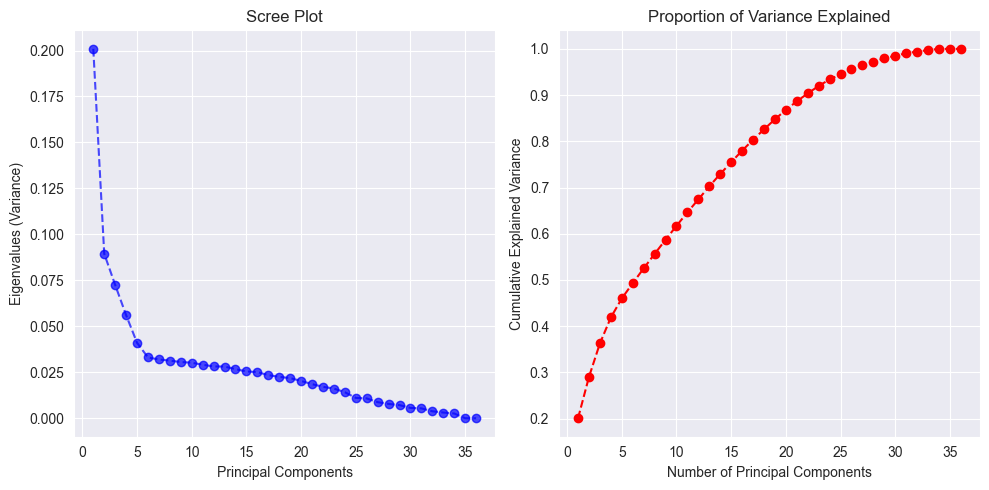

In [408]:
pca = PCA()
principal_components = pca.fit_transform(dff_nums_scaled)

# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create Scree Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color="b",marker='o', linestyle='--')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues (Variance)')
plt.title('Scree Plot')

# Create Cumulative Variance Plot
plt.subplot(1,2,2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color="r")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Proportion of Variance Explained')

# Show plots
plt.tight_layout()
plt.show()

### Based on the plot we see that PCA is not acceptable for dimensionality reduction as the partial elbow obtained only explains 40-50% of variance.

## Creating Final Dataset for Train-Test Split

We will standard scale (done in PCA step) and one-hot encode (without removing a columns as we will use regression without a constant) to get a final format of the data which we will use for train and test split.

In [409]:
dff_cat=dff[cols_cat].copy()

In [410]:
dff_cat_enc=pd.get_dummies(dff_cat,columns=cols_cat,drop_first=False)

In [411]:
dff_cat_enc.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,False,False,False,True,False,False,True,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3,False,False,False,True,False,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,False,True,False,False,False,False,True,False


In [412]:
dff_final=pd.concat([dff_nums_scaled,dff_cat_enc],axis=1)
dff_final['SalePrice']=dff['SalePrice']
dff_final.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.073375,-0.237958,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.509574,0.575425,-0.288653,...,False,False,True,False,False,False,False,True,False,208500
1,-0.872563,0.375205,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.574516,1.171992,-0.288653,...,False,False,True,False,False,False,False,True,False,181500
2,0.073375,-0.115326,0.073480,0.651479,-0.517200,0.984752,0.830215,0.321517,0.092907,-0.288653,...,False,False,True,False,False,False,False,True,False,223500
3,0.309859,-0.442346,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.574516,-0.499274,-0.288653,...,False,False,True,True,False,False,False,False,False,140000
4,0.073375,0.538716,0.375148,1.374795,-0.517200,0.951632,0.733308,1.361359,0.463568,-0.288653,...,False,False,True,False,False,False,False,True,False,250000


### dff_final is the final format of the dataframe which we will call on when we repeatedly want a Train and Test Split. (will be seen later)

## Functions for Naive Regression

We will now perform Naive Regression or simple Multiple Linear Regression with the following optimisations in mind:
1. We will first remove Multicollinearity between features by removing variables with VIF greater than 10
2. We will then perform regression and remove features that have p values greater than 0.05
3. We will then remove data points iteratively using Cook's Distance until R_(square)_adj does not decrease.

In [413]:
def MLR(y_train,X_train):
    model_LR=sm.OLS(y_train,X_train)
    results_LR=model_LR.fit()
    return results_LR

In [414]:
def residual_plot(results_LR):
    influence = results_LR.get_influence()
    studentized_residuals = influence.resid_studentized_external

    # Plot studentized residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(results_LR.fittedvalues, studentized_residuals, edgecolors='k', alpha=0.7)
    plt.axhline(y=0, color='grey', linestyle='--')
    plt.axhline(y=2, color='red', linestyle='--', label='Threshold (±2)')
    plt.axhline(y=-2, color='red', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Studentized Residuals')
    plt.title('Studentized Residual Plot')
    plt.legend()
    plt.show()

In [415]:
def cook_distance_plot(results_LR):
    influence = results_LR.get_influence()
    cooks_d = influence.cooks_distance[0]
    # Plot Cook's Distance
    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(len(cooks_d)), cooks_d, basefmt=" ", markerfmt=',')
    threshold = 4 / len(cooks_d)
    plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold (4/n = {threshold:.4f})")
    plt.xlabel('Observation index')
    plt.ylabel("Cook's Distance")
    plt.title("Cook's Distance Plot")
    plt.legend()
    plt.show()

In [416]:
def remove_influential_pts(results_LR,X_train,y_train):
    influence = results_LR.get_influence()
    cooks_d = influence.cooks_distance[0]
    threshold = 4 / len(cooks_d)
    # Identify influential points (Cook's Distance > 4/n)
    influential_points = np.where(cooks_d > threshold)[0]

    # Remove influential points from datasets:
    X_train_infl_rem = X_train.drop(X_train.index[influential_points])
    y_train_infl_rem = y_train.drop(y_train.index[influential_points])

    # Return after removing influential points
    return X_train_infl_rem, y_train_infl_rem


In [417]:
def residuals_qqplot(model_result):
    # Extract residuals from model result
    residuals = model_result.resid

    # Generate Q-Q plot
    sm.qqplot(residuals, line='45', fit=True)
    plt.title('Q-Q Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid(True)
    plt.show()

In [418]:
def residuals_f_test(model_result):

    # Extract residuals
    residuals = model_result.resid

    # Split residuals into two groups for F-test
    mid_point = len(residuals) // 2
    group1 = residuals[:mid_point]
    group2 = residuals[mid_point:]

    # Perform F-test
    f_stat, p_value = f_oneway(group1, group2)
    print("=================Statistical Test of Normality of Residuals Results======================")
    # Print test results
    print('F-Test Statistics:', f_stat)
    print('P-Value:', p_value)
    if p_value > 0.05:
        print("Residuals likely follow a normal distribution (Fail to reject H0).")
    else:
        print("Residuals may not follow a normal distribution (Reject H0).")

In [419]:
def remove_insignificant_features(X_train, y_train, p_threshold=0.05):

    X = X_train.copy()
    y = y_train.copy()

    # Initial model
    model = sm.OLS(y, X)
    results = model.fit()

    while True:
        # Exclude intercept from p-value check
        p_values = results.pvalues

        # Find max p-value
        max_pval = p_values.max()

        if max_pval > p_threshold:
            # Identify feature with highest p-value
            feature_to_remove = p_values.idxmax()
            print(f"Removing feature: {feature_to_remove} with p-value: {max_pval:.4f}")

            # Drop this feature
            X.drop(columns=feature_to_remove, inplace=True)

            # Refit model
            model = sm.OLS(y, X)
            results = model.fit()
        else:
            break

    return X

In [420]:
def compute_vif_no_const(X):
    vif_data = pd.DataFrame()
    vif_data['feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [421]:
def remove_high_vif_features(X_train, threshold=10.0):

    X_mod = X_train.copy()

    while True:
        # Recompute VIF
        vif_df = compute_vif_no_const(X_mod)

        # Find any VIFs that are NaN or too high
        high_vif_features = vif_df[
            (vif_df['VIF'].isna()) | (vif_df['VIF'] > threshold)
        ]

        if high_vif_features.empty:
            break  # All features have acceptable VIF

        # Feature to remove: highest VIF or NaN
        feature_to_remove = high_vif_features.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Removing '{feature_to_remove}' with VIF = {high_vif_features.sort_values('VIF', ascending=False).iloc[0]['VIF']:.4f}")

        X_mod.drop(columns=[feature_to_remove], inplace=True)

    return X_mod

### Train-Test split for Naive Regression Setting

In [422]:
X=dff_final.drop('SalePrice',axis=1)
y=dff_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.astype(float)
X_test=X_test.astype(float)

### Removing Multicollinearity

In [423]:
vif_df = compute_vif_no_const(X_train)
print(vif_df)

                   feature        VIF
0               MSSubClass  53.120611
1              LotFrontage   4.836162
2                  LotArea   5.448950
3              OverallQual   5.627851
4              OverallCond   2.687172
..                     ...        ...
261  SaleCondition_AdjLand        inf
262   SaleCondition_Alloca        inf
263   SaleCondition_Family        inf
264   SaleCondition_Normal        inf
265  SaleCondition_Partial        inf

[266 rows x 2 columns]


In [424]:
X_train=remove_high_vif_features(X_train, threshold=10.0)

Removing 'Exterior2nd_AsphShn' with VIF = inf
Removing 'Exterior1st_Wd Sdng' with VIF = inf
Removing 'SaleCondition_Partial' with VIF = inf
Removing 'Exterior2nd_CBlock' with VIF = inf
Removing 'PavedDrive_Y' with VIF = inf
Removing 'RoofMatl_WdShake' with VIF = inf
Removing 'SaleType_WD' with VIF = inf
Removing 'RoofStyle_Mansard' with VIF = inf
Removing 'GarageFinish_RFn' with VIF = inf
Removing 'GarageType_CarPort' with VIF = inf
Removing 'HouseStyle_SFoyer' with VIF = inf
Removing 'GarageCond_TA' with VIF = inf
Removing 'KitchenQual_TA' with VIF = inf
Removing 'BldgType_Twnhs' with VIF = inf
Removing 'Electrical_FuseP' with VIF = inf
Removing 'Condition2_RRNn' with VIF = inf
Removing 'GarageQual_TA' with VIF = inf
Removing 'HeatingQC_Ex' with VIF = inf
Removing 'Condition1_RRNe' with VIF = inf
Removing 'BsmtFinType2_GLQ' with VIF = inf
Removing 'BsmtFinType1_GLQ' with VIF = inf
Removing 'Neighborhood_Timber' with VIF = inf
Removing 'BsmtCond_Po' with VIF = inf
Removing 'BsmtQual_Fa

### Performing Naive Regression (1st Pass)

=================R^2 Value======================
0.9809921494455621
=================Adj R^2 Value======================
0.9772061915322552
=================Statistical Test of Normality of Residuals Results======================
F-Test Statistics: 0.1788783912103518
P-Value: 0.6724168992656281
Residuals likely follow a normal distribution (Fail to reject H0).


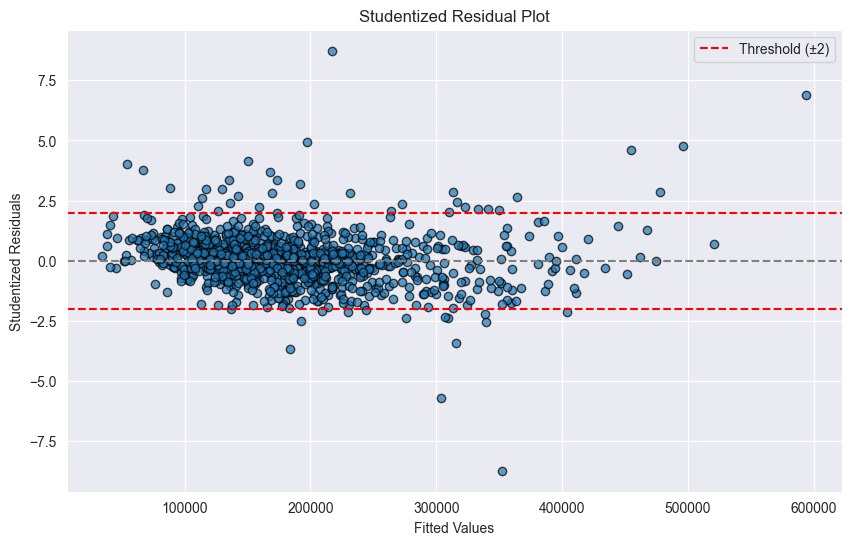

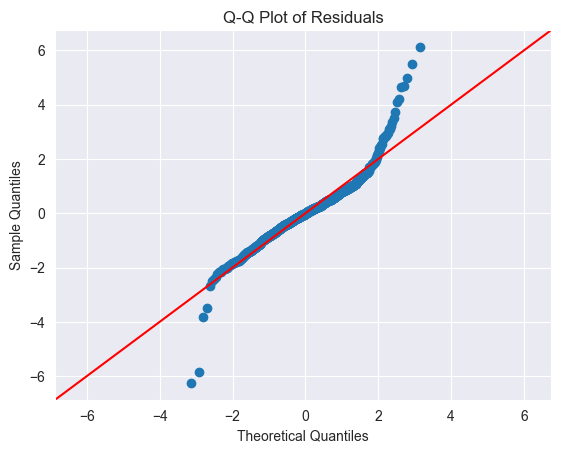

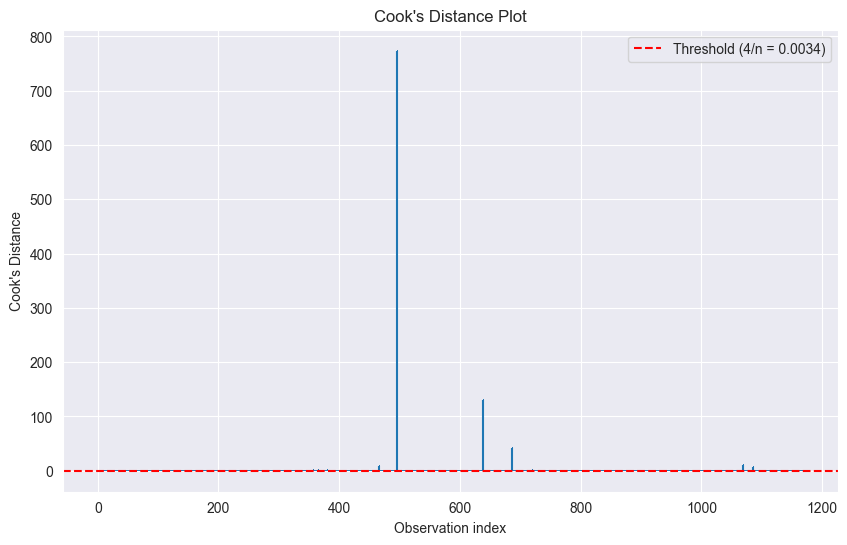

In [425]:
MLR_naive_results=MLR(y_train,X_train)
print("=================R^2 Value======================")
print(MLR_naive_results.rsquared)
print("=================Adj R^2 Value======================")
print(MLR_naive_results.rsquared_adj)
residuals_f_test(MLR_naive_results)
residual_plot(MLR_naive_results)
residuals_qqplot(MLR_naive_results)
cook_distance_plot(MLR_naive_results)

In [426]:
MLR_naive_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              259.1
Date:                Fri, 11 Apr 2025   Prob (F-statistic):                        0.00
Time:                        05:39:37   Log-Likelihood:                         -13583.
No. Observations:                1168   AIC:                                  2.755e+04
Df Residuals:                     974   BIC:                                  2.854e+04
Df Model:                         194                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MSSubClass            -2.118e+04   2584.430     -8.194      0.000   -2.62e+04   -1.61e+04
LotFrontage           -1312.2296   1692.756     -0.775      0.438   -4634.099    2009.640
LotArea                6268.9547   1656.217      3.785      0.000    3018.790    9519.120
OverallQual            1.179e+04   2030.625      5.804      0.000    7800.097    1.58e+04
OverallCond            2312.4959   1345.175      1.719      0.086    -327.280    4952.271
YearRemodAdd           4319.4258   1664.655      2.595      0.010    1052.702    7586.150
MasVnrArea             3758.0836   1321.247      2.844      0.005    1165.264    6350.903
BsmtFinSF2            -6388.4341   1564.484     -4.083      0.000   -9458.582   -3318.286
BsmtUnfSF             -1.189e+04   2019.953     -5.886      0.000   -1.59e+04   -7924.971
TotalBsmtSF             2.97e+04   2524.068     11.768      0.000    2.47e+04    3.47e+04
LowQualFinSF          -1920.0590   1381.089     -1.390      0.165   -4630.311     790.193
BsmtFullBath           2999.4002   1500.762      1.999      0.046      54.301    5944.499
BsmtHalfBath          -1034.3010   1054.644     -0.981      0.327   -3103.937    1035.335
FullBath               8410.7252   1671.089      5.033      0.000    5131.375    1.17e+04
HalfBath               1936.2010   1451.187      1.334      0.182    -911.613    4784.015
BedroomAbvGr          -3652.2191   1631.889     -2.238      0.025   -6854.641    -449.797
KitchenAbvGr          -4595.4793   1733.678     -2.651      0.008   -7997.653   -1193.306
TotRmsAbvGrd           7667.5364   2012.873      3.809      0.000    3717.470    1.16e+04
Fireplaces             3541.9006   1247.435      2.839      0.005    1093.931    5989.871
GarageYrBlt            6644.0442   2187.849      3.037      0.002    2350.604    1.09e+04
GarageCars             1467.1399   2398.057      0.612      0.541   -3238.813    6173.093
GarageArea             4675.0402   2443.167      1.914      0.056    -119.437    9469.518
WoodDeckSF              587.7154   1056.276      0.556      0.578   -1485.124    2660.555
OpenPorchSF            -165.2637   1064.671     -0.155      0.877   -2254.577    1924.050
EnclosedPorch         -1705.8554   1078.848     -1.581      0.114   -3822.989     411.279
3SsnPorch              1670.6659    892.374      1.872      0.061     -80.532    3421.863
ScreenPorch             474.5377    996.387      0.476      0.634   -1480.774    2429.850
PoolArea               3659.9961   1092.860      3.349      0.001    1515.366    5804.627
MiscVal                -381.7459    924.434     -0.413      0.680   -2195.858    1432.366
MoSold                -1498.3612    977.264     -1.533      0.126   -3416.147     419.425
YrSold        

### Removing Insignificant Features

In [427]:
X_train_2=remove_insignificant_features(X_train, y_train, p_threshold=0.05)

Removing feature: GarageCond_Fa with p-value: 0.9977
Removing feature: MSZoning_RH with p-value: 0.9906
Removing feature: HeatingQC_Fa with p-value: 0.9728
Removing feature: GarageQual_Fa with p-value: 0.9568
Removing feature: RoofMatl_WdShngl with p-value: 0.9395
Removing feature: Condition1_PosN with p-value: 0.9347
Removing feature: YrSold with p-value: 0.9074
Removing feature: SaleCondition_Abnorml with p-value: 0.8897
Removing feature: OpenPorchSF with p-value: 0.8895
Removing feature: GarageType_Detchd with p-value: 0.8724
Removing feature: Exterior1st_BrkComm with p-value: 0.8604
Removing feature: Exterior2nd_AsbShng with p-value: 0.8329
Removing feature: ExterCond_Po with p-value: 0.8321
Removing feature: BsmtFinType2_BLQ with p-value: 0.8271
Removing feature: RoofMatl_Tar&Grv with p-value: 0.8167
Removing feature: PavedDrive_P with p-value: 0.7936
Removing feature: Condition2_Feedr with p-value: 0.7872
Removing feature: SaleType_ConLI with p-value: 0.7797
Removing feature: Hea

In [428]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 80 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSubClass            1168 non-null   float64
 1   LotArea               1168 non-null   float64
 2   OverallQual           1168 non-null   float64
 3   OverallCond           1168 non-null   float64
 4   MasVnrArea            1168 non-null   float64
 5   BsmtFinSF2            1168 non-null   float64
 6   BsmtUnfSF             1168 non-null   float64
 7   TotalBsmtSF           1168 non-null   float64
 8   BsmtFullBath          1168 non-null   float64
 9   FullBath              1168 non-null   float64
 10  HalfBath              1168 non-null   float64
 11  BedroomAbvGr          1168 non-null   float64
 12  KitchenAbvGr          1168 non-null   float64
 13  TotRmsAbvGrd          1168 non-null   float64
 14  Fireplaces            1168 non-null   float64
 15  GarageYrBlt           11

### Again removing Multicollinearity (as we removed some features)

In [429]:
X_train_2=remove_high_vif_features(X_train_2, threshold=10.0)

### No points were removed by the algorithm

### Again Performing Naive Regression (2nd Pass)

=================R^2 Value======================
0.9785849519585219
=================Adj R^2 Value======================
0.9770103160731191
=================Statistical Test of Normality of Residuals Results======================
F-Test Statistics: 0.04417869304519306
P-Value: 0.8335582278042254
Residuals likely follow a normal distribution (Fail to reject H0).


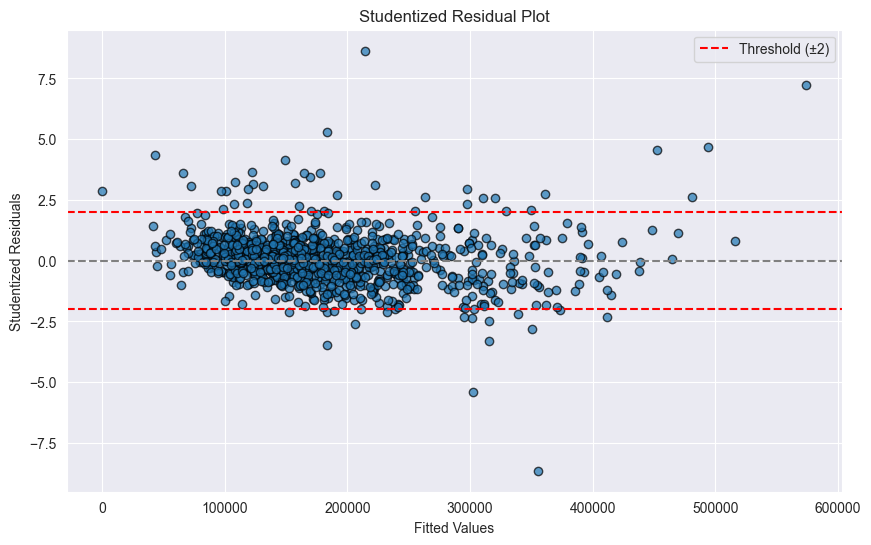

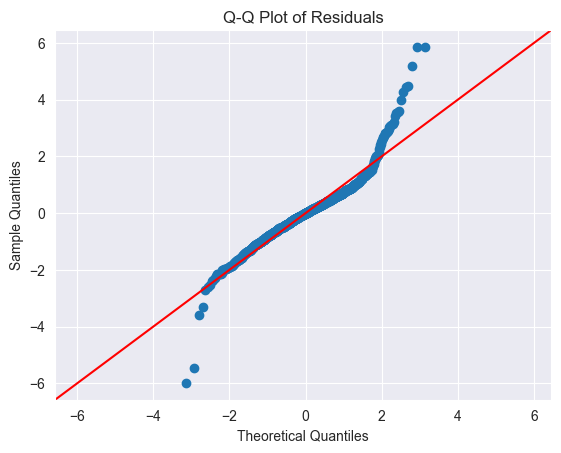

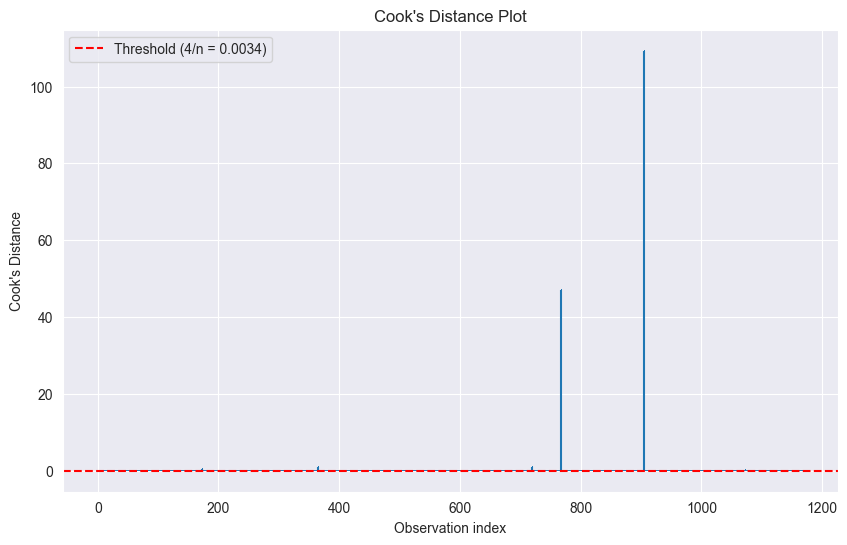

In [430]:
MLR_naive_results_redun_removed=MLR(y_train,X_train_2)
print("=================R^2 Value======================")
print(MLR_naive_results_redun_removed.rsquared)
print("=================Adj R^2 Value======================")
print(MLR_naive_results_redun_removed.rsquared_adj)
residuals_f_test(MLR_naive_results_redun_removed)
residual_plot(MLR_naive_results_redun_removed)
residuals_qqplot(MLR_naive_results_redun_removed)
cook_distance_plot(MLR_naive_results_redun_removed)

### Removing points based on Cook's Distance until R_sqr_Adj no longer increases (threshold: 4/n)

In [431]:
model_counter=MLR_naive_results_redun_removed
X_train_cpy=X_train_2.copy()
y_train_cpy=y_train.copy()
while True:
    X_train_infl_rem, y_train_infl_rem = remove_influential_pts(model_counter,X_train_cpy,y_train_cpy)
    model_new = MLR(y_train_infl_rem, X_train_infl_rem)
    if model_new.rsquared_adj > model_counter.rsquared_adj:
        model_counter = model_new
        X_train_cpy = X_train_infl_rem.copy()
        y_train_cpy = y_train_infl_rem.copy()
    else:
        break

### Checking VIF

In [432]:
vif_df=compute_vif_no_const(X_train_cpy)
vif_df

,feature,VIF
0,MSSubClass,6.379524
1,LotArea,1.534030
2,OverallQual,4.388207
3,OverallCond,1.465220
4,MasVnrArea,1.881136
...,...,...
75,GarageFinish_Unf,4.417987
76,GarageQual_Ex,3.810654
77,GarageCond_Ex,3.592812
78,SaleType_New,1.626574


### All VIFs were ok. So we conclude our Naive Regression Process Optimisation process and get final Train Regression Results

=================R^2 Value======================
R^2: 0.9785849519585219
=================Adj R^2 Value======================
adjusted R^2: 0.9770103160731191
=================Statistical Test of Normality of Residuals Results======================
F-Test Statistics: 0.04417869304519306
P-Value: 0.8335582278042254
Residuals likely follow a normal distribution (Fail to reject H0).


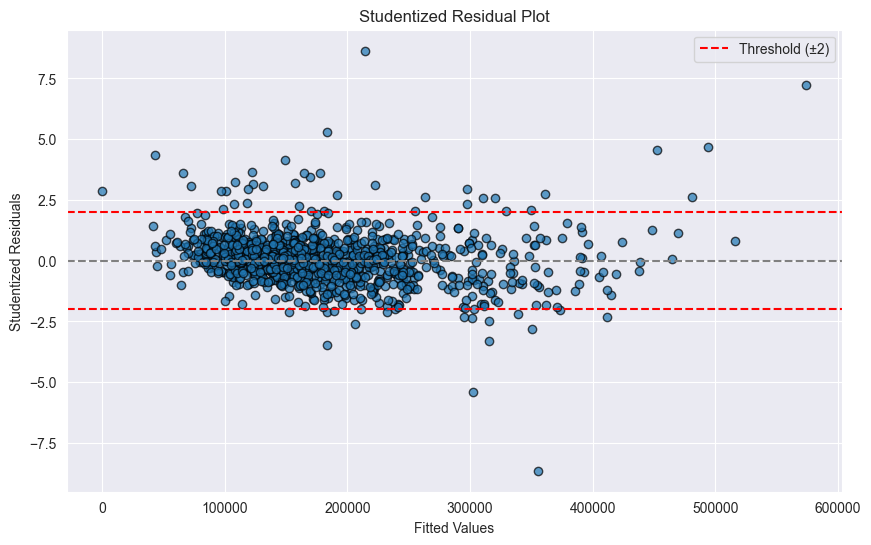

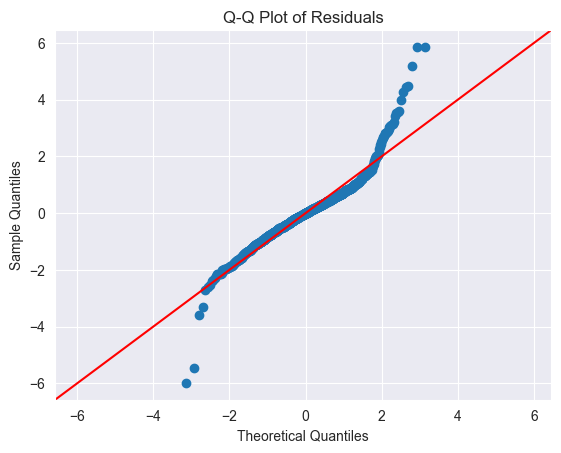

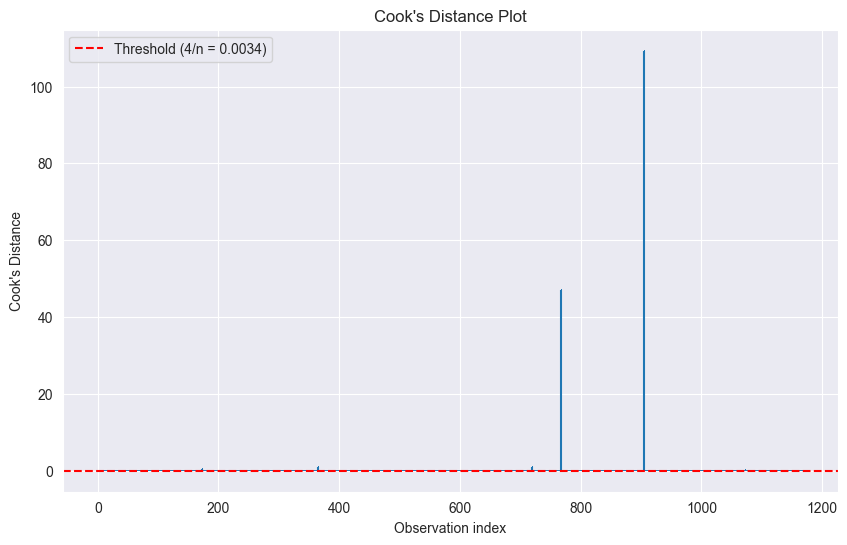

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              621.5
Date:                Fri, 11 Apr 2025   Prob (F-statistic):                        0.00
Time:                        05:40:32   Log-Likelihood:                         -13653.
No. Observations:                1168   AIC:                                  2.747e+04
Df Residuals:                    1088   BIC:                                  2.787e+04
Df Model:                          80                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MSSubClass           -2.072e+04   2197.872     -9.426      0.000    -2.5e+04   -1.64e+04
LotArea               6667.3585   1005.163      6.633      0.000    4695.082    8639.635
OverallQual           1.097e+04   1853.184      5.922      0.000    7338.011    1.46e+04
OverallCond           4991.1987   1055.944      4.727      0.000    2919.281    7063.117
MasVnrArea            3651.2538   1257.072      2.905      0.004    1184.694    6117.813
BsmtFinSF2           -4427.7752   1083.374     -4.087      0.000   -6553.514   -2302.037
BsmtUnfSF            -1.089e+04   1882.884     -5.782      0.000   -1.46e+04   -7191.938
TotalBsmtSF           2.933e+04   2351.222     12.473      0.000    2.47e+04    3.39e+04
BsmtFullBath          2642.8470   1293.340      2.043      0.041     105.123    5180.571
FullBath              9186.5387   1522.364      6.034      0.000    6199.437    1.22e+04
HalfBath              3293.1116   1315.046      2.504      0.012     712.799    5873.424
BedroomAbvGr         -3281.6715   1473.916     -2.226      0.026   -6173.711    -389.632
KitchenAbvGr         -3520.7678   1230.142     -2.862      0.004   -5934.487   -1107.048
TotRmsAbvGrd          7522.5952   1870.700      4.021      0.000    3852.008    1.12e+04
Fireplaces            3426.9607   1140.660      3.004      0.003    1188.818    5665.104
GarageYrBlt           6457.1247   1763.490      3.662      0.000    2996.898    9917.351
GarageArea            4502.9186   1374.858      3.275      0.001    1805.246    7200.592
PoolArea              3410.3317    973.063      3.505      0.000    1501.038    5319.625
LandContour_HLS       2.877e+04   5709.426      5.040      0.000    1.76e+04       4e+04
LotConfig_Corner      4929.5911   2329.762      2.116      0.035     358.257    9500.926
LotConfig_CulDSac      1.02e+04   3656.724      2.791      0.005    3029.813    1.74e+04
Neighborhood_Blmngtn  1.189e+05   9821.115     12.109      0.000    9.97e+04    1.38e+05
Neighborhood_Blueste  1.171e+05   3.08e+04      3.808      0.000    5.68e+04    1.78e+05
Neighborhood_BrDale    1.19e+05   1.02e+04     11.613      0.000    9.89e+04    1.39e+05
Neighborhood_BrkSide  1.228e+05   6352.608     19.326      0.000     1.1e+05    1.35e+05
Neighborhood_ClearCr  1.029e+05   8193.107     12.559      0.000    8.68e+04    1.19e+05
Neighborhood_CollgCr  1.148e+05   4595.527     24.991      0.000    1.06e+05    1.24e+05
Neighborhood_Crawfor  1.279e+05   6318.156     20.239      0.000    1.15e+05     1.4e+05
Neighborhood_Edwards  1.085e+05   5014.947     21.631      0.000    9.86e+04    1.18e+05
Neighborhood_Gilbert  9.876e+04   5483.749     18.010      0.000     8.8e+04     1.1e+05
Neighborhood_IDOTRR    1.05e+05   7621.479     

In [433]:
print("=================R^2 Value======================")
print("R^2:",model_counter.rsquared)
print("=================Adj R^2 Value======================")
print("adjusted R^2:",model_counter.rsquared_adj)
residuals_f_test(model_counter)
residual_plot(model_counter)
residuals_qqplot(model_counter)
cook_distance_plot(model_counter)
model_counter.summary()

In [434]:
X_train_final_1=X_train_cpy.copy()
y_train_final_1=y_train_cpy.copy()

## Getting Test Performance of Naive Regression

In [445]:
LR=LinearRegression(fit_intercept=False)
LR.fit(X_train_final_1,y_train_final_1)
y_pred=LR.predict(X_test[X_train_final_1.columns])
rmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
r2=r2_score(y_test,y_pred)
print("RMSE:",rmse)
print("R2 Score:",r2)

RMSE: 0.2398874716850137
R2 Score: 0.8159751747709123


## Very Poor Performance due to the Curse of Dimensionality of High Dimensional Data

When number of features are increasing the joint values of all the p-values of the features cannot be trusted as the confidence decreases polynomially with the 0.95 fraction (the standard confidence taken). To counter act multiple testing problems we use F-Test but to find the true association between p number of features we need to perform 2^p Regression which is infeasible therefore we will try out Heauristics to reduce this Search Space like:
1. Forward Selection
2. Ridge Regression
3. Lasso Regression

## Forward Selection

We will iteratively choose the best single feature out of all the features (i.e. which gives lowest MSE) now keeping that obtained feature constant we will try out higher number of features each time selecting the best addition to the regressors. Essentially we are choosing greedily until I exhaust all the features. Then we will select the best set of Features for which the CV MSE was the lowest.

In [436]:
X=dff_final.drop('SalePrice',axis=1)
y=dff_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.astype(float)
X_test=X_test.astype(float)

In [438]:
def forward_selection(X_train, y_train, cv=5, verbose=True):
    remaining_features = list(X_train.columns)
    selected_features = []
    cv_mse_history = {}
    best_cv_mse = np.inf

    for step in range(1, len(X_train.columns) + 1):
        best_feature = None
        best_step_mse = np.inf

        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_subset = X_train[current_features]

            # Cross-validated negative MSE (sklearn uses score -> higher is better)
            scores = cross_val_score(
                LinearRegression(fit_intercept=False),
                X_subset,
                y_train,
                cv=cv,
                scoring=make_scorer(mean_squared_error, greater_is_better=False)
            )

            avg_mse = -scores.mean()  # Flip the sign to get actual MSE

            if avg_mse < best_step_mse:
                best_step_mse = avg_mse
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            cv_mse_history[step] = (selected_features.copy(), best_step_mse)

            if verbose:
                print(f"Step {step}: Added '{best_feature}', CV-MSE = {best_step_mse:.4f}")

            if best_step_mse < best_cv_mse:
                best_cv_mse = best_step_mse
                best_features_final = selected_features.copy()

    X_mod = X_train[best_features_final]
    return X_mod, best_cv_mse, cv_mse_history

In [439]:
X_mod, best_mse, mse_history = forward_selection(X_train, y_train, cv=5)
print("Best subset of features:", X_mod.columns.tolist())
print("Lowest CV-MSE:", best_mse)

Step 1: Added 'Utilities_AllPub', CV-MSE = 5985165851.1406
Step 2: Added 'OverallQual', CV-MSE = 2310153170.9511
Step 3: Added 'GrLivArea', CV-MSE = 1817697504.4886
Step 4: Added 'BsmtQual_Ex', CV-MSE = 1605446724.6339
Step 5: Added 'GarageCars', CV-MSE = 1473355197.6670
Step 6: Added 'BsmtFullBath', CV-MSE = 1388489713.7409
Step 7: Added 'MSSubClass', CV-MSE = 1316247288.8731
Step 8: Added 'YearBuilt', CV-MSE = 1272224806.1493
Step 9: Added 'KitchenQual_Ex', CV-MSE = 1227001137.7318
Step 10: Added 'OverallCond', CV-MSE = 1188843182.9861
Step 11: Added 'Neighborhood_NoRidge', CV-MSE = 1146345333.8461
Step 12: Added 'LotArea', CV-MSE = 1112020334.1081
Step 13: Added 'Neighborhood_StoneBr', CV-MSE = 1080365704.0722
Step 14: Added 'Neighborhood_NridgHt', CV-MSE = 1052071155.1443
Step 15: Added 'Neighborhood_Crawfor', CV-MSE = 1022623635.4580
Step 16: Added 'BsmtExposure_No', CV-MSE = 1001809806.1050
Step 17: Added 'Exterior1st_BrkFace', CV-MSE = 984896419.2257
Step 18: Added 'Neighborhood

In [441]:
X_train_final_2=X_mod.copy()
y_train_final_2=y_train.copy()

## Test Performance of Forward Selection

In [444]:
LR=LinearRegression(fit_intercept=False)
LR.fit(X_train_final_2,y_train_final_2)
y_pred=LR.predict(X_test[X_train_final_2.columns])
rmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
r2=r2_score(y_test,y_pred)
print("RMSE:",rmse)
print("R2 Score:",r2)

RMSE: 0.1599056974774472
R2 Score: 0.890233844898767


### A massive Improvement over the previous Naive MLR model.

## Ridge Regression

We will perform GRIDSEARCHCV using an alpha parameter space and then create a tolerance variable where after getting the best GRIDSEARCHCV Ridge regression model we will drop those features that have weights less than the tolerance we will then again perform GRIDSEARCHCV to get the solution. We will iterate until no features can be dropped.

In [448]:
X=dff_final.drop('SalePrice',axis=1)
y=dff_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.astype(float)
X_test=X_test.astype(float)

In [449]:
def tune_ridge_regression(X_train, y_train, alpha_grid, cv=5, fit_intercept=False, verbose=True):
    ridge = Ridge(fit_intercept=fit_intercept)

    param_grid = {'alpha': alpha_grid}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    ridge_cv = GridSearchCV(
        ridge,
        param_grid,
        scoring=scorer,
        cv=cv,
        return_train_score=True
    )

    ridge_cv.fit(X_train, y_train)

    best_alpha = ridge_cv.best_params_['alpha']
    best_score = -ridge_cv.best_score_  # Make it positive since we negated MSE earlier

    if verbose:
        print(f"Best alpha: {best_alpha}")
        print(f"Lowest CV-MSE: {best_score:.4f}")

    return best_alpha, best_score, ridge_cv

In [450]:
def plot_ridge_cv_results(ridge_cv, alphas):
    mse_scores = -ridge_cv.cv_results_['mean_test_score']

    plt.figure(figsize=(8, 5))
    plt.semilogx(alphas, mse_scores, marker='o', color='teal')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Cross-Validated MSE')
    plt.title('Ridge Regression Hyperparameter Tuning')
    plt.grid(True)
    plt.show()

In [465]:
def remove_low_weight_features(model, X_train, tolerance=1e-5, verbose=True):
    coef = model.coef_
    feature_names = X_train.columns

    # Identify low-weight features
    low_weight_features = [feat for feat, weight in zip(feature_names, coef)
                           if abs(weight) < tolerance]

    # Drop those columns
    X_mod = X_train.drop(columns=low_weight_features)

    if verbose:
        print(f"Dropping {len(low_weight_features)} feature(s) with |coef| < {tolerance}")
        print(low_weight_features)

    return low_weight_features, X_mod

In [461]:
# Define alpha grid
alphas = np.logspace(-3, 3, 50)

# Tune Ridge Regression
best_alpha, best_mse, ridge_cv = tune_ridge_regression(X_train, y_train, alphas,cv=10)

Best alpha: 14.563484775012444
Lowest CV-MSE: 1105567194.3539


### The CV-MSE for one run of GRIDSEARCHCV over the alpha params space

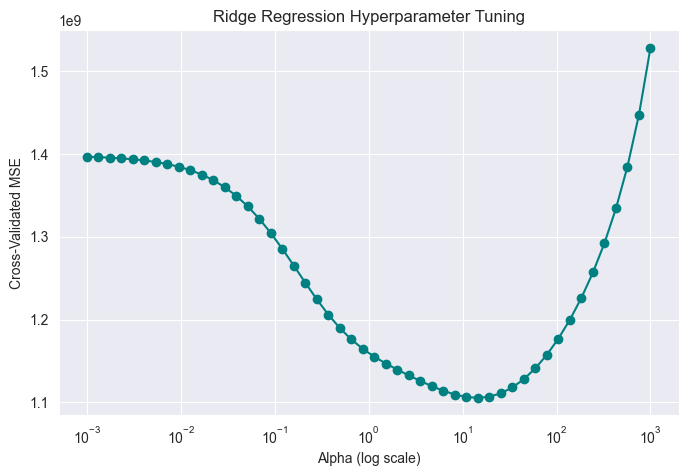

In [462]:
plot_ridge_cv_results(ridge_cv, alphas)

In [463]:
best_ridge_model = ridge_cv.best_estimator_
coefficients = best_ridge_model.coef_
feature_names = X_train.columns

# Combine into a dataframe for better readability
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute value of coefficients (optional)
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Drop helper column if not needed
coef_df.drop(columns='Abs_Coefficient', inplace=True)

print(coef_df)

                  Feature   Coefficient
76   Neighborhood_NoRidge  24040.587378
83   Neighborhood_StoneBr  21553.824241
122      RoofMatl_ClyTile -20512.678991
176           BsmtQual_Ex  20354.322114
218        KitchenQual_Ex  19211.725683
..                    ...           ...
33                MiscVal    -13.362602
108     HouseStyle_1.5Fin      4.066913
256        SaleType_ConLw     -3.050770
216        Electrical_Mix      0.000000
124      RoofMatl_Membran      0.000000

[266 rows x 2 columns]


In [467]:
# Remove low-weight features
dropped_feats, X_mod = remove_low_weight_features(best_ridge_model, X_train, tolerance=1e-2)

Dropping 2 feature(s) with |coef| < 0.01
['RoofMatl_Membran', 'Electrical_Mix']


### Test Set Performance of Ridge Regression (for one pass of GRIDSEARCHCV)

In [468]:
y_pred=best_ridge_model.predict(X_test)
rmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
r2=r2_score(y_test,y_pred)
print("RMSE:",rmse)
print("R2 Score:",r2)

RMSE: 0.15519662364174802
R2 Score: 0.8797109698607661


In [471]:
def recursive_ridge_feature_selection(X_train, y_train, alpha_grid, cv=5, fit_intercept=False, tolerance=1e-5,verbose=True):
    X_mod = X_train.copy()
    iteration = 1

    while True:
        if verbose:
            print(f"\n🔁 Iteration {iteration} - Tuning Ridge on {X_mod.shape[1]} features")

        # Step 1: Tune ridge on current feature set
        best_alpha, best_score, ridge_cv = tune_ridge_regression(
            X_mod, y_train, alpha_grid, cv=cv, fit_intercept=fit_intercept, verbose=verbose
        )

        best_model = ridge_cv.best_estimator_

        # Step 2: Remove low-weight features
        low_weight_features, X_new = remove_low_weight_features(best_model, X_mod, tolerance=tolerance, verbose=verbose)

        # Stop if no features were removed
        if len(low_weight_features) == 0:
            if verbose:
                print("✅ Convergence reached: No more low-weight features to drop.")
            break

        # Else, continue with reduced feature set
        X_mod = X_new
        iteration += 1

    return best_alpha, X_mod, best_model

In [472]:
alphas = np.logspace(-3, 3, 50)

best_alpha, X_mod_final, final_ridge_model = recursive_ridge_feature_selection(
    X_train, y_train, alpha_grid=alphas, cv=5, tolerance=1e-2, verbose=True
)

print("Final number of features:", X_mod_final.shape[1])


🔁 Iteration 1 - Tuning Ridge on 266 features
Best alpha: 14.563484775012444
Lowest CV-MSE: 1138030328.6468
Dropping 2 feature(s) with |coef| < 0.01
['RoofMatl_Membran', 'Electrical_Mix']

🔁 Iteration 2 - Tuning Ridge on 264 features
Best alpha: 14.563484775012444
Lowest CV-MSE: 1138030328.6468
Dropping 0 feature(s) with |coef| < 0.01
[]
✅ Convergence reached: No more low-weight features to drop.
Final number of features: 264


### Final Optimised Test Performance of Ridge Regression

In [474]:
y_pred=final_ridge_model.predict(X_test[X_mod_final.columns])
rmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
r2=r2_score(y_test,y_pred)
print("RMSE:",rmse)
print("R2 Score:",r2)

RMSE: 0.15519662364174724
R2 Score: 0.8797109698607666


### The performance is a bit worse off than Forward Selection maybe it is picking up more noise features as it does not regularise features to 0

## Lasso Regression

The idea for Lasso Regression is same as for Ridge Regression where we will iteratively call GRIDSEARCHCV until no features are dropped. (One small change is that the Lasso inherently drops features and we do not need to define a tolerance variable as in the case of Ridge Regression)

In [485]:
X=dff_final.drop('SalePrice',axis=1)
y=dff_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train=X_train.astype(float)
X_test=X_test.astype(float)

In [486]:
def tune_lasso_regression(X_train, y_train, alpha_grid, cv=5, fit_intercept=False, verbose=True):
    lasso = Lasso(fit_intercept=fit_intercept, max_iter=10000)

    param_grid = {'alpha': alpha_grid}
    scorer = make_scorer(mean_squared_error, greater_is_better=False)

    lasso_cv = GridSearchCV(
        lasso,
        param_grid,
        scoring=scorer,
        cv=cv,
        return_train_score=True
    )

    lasso_cv.fit(X_train, y_train)

    best_alpha = lasso_cv.best_params_['alpha']
    best_score = -lasso_cv.best_score_

    if verbose:
        print(f"Best alpha: {best_alpha}")
        print(f"Lowest CV-MSE: {best_score:.4f}")

    return best_alpha, best_score, lasso_cv

In [487]:
def remove_zero_weight_features(model, X_train, verbose=True):
    coef = model.coef_
    feature_names = X_train.columns

    # Identify features with exactly zero weight
    zero_weight_features = [feat for feat, weight in zip(feature_names, coef)
                            if weight == 0.0]

    # Drop zero-weight features
    X_mod = X_train.drop(columns=zero_weight_features)

    if verbose:
        print(f"🗑️ Dropping {len(zero_weight_features)} feature(s) with coefficient = 0")
        print(zero_weight_features)

    return zero_weight_features, X_mod

In [488]:
def recursive_lasso_feature_selection(X_train, y_train, alpha_grid, cv=5,fit_intercept=False, verbose=True):
    X_mod = X_train.copy()
    iteration = 1

    while True:
        if verbose:
            print(f"\n🔁 Iteration {iteration} - Tuning Lasso on {X_mod.shape[1]} features")

        # Step 1: Tune Lasso on current feature set
        best_alpha, best_score, lasso_cv = tune_lasso_regression(
            X_mod, y_train, alpha_grid, cv=cv, fit_intercept=fit_intercept, verbose=verbose
        )

        best_model = lasso_cv.best_estimator_

        # Step 2: Remove features with coef == 0
        zero_weight_features, X_new = remove_zero_weight_features(best_model, X_mod, verbose=verbose)

        # Stop if no features were removed
        if len(zero_weight_features) == 0:
            if verbose:
                print("✅ Convergence reached: No more zero-weight features to drop.")
            break

        # Update feature set
        X_mod = X_new
        iteration += 1

    return best_alpha, X_mod, best_model

In [490]:
alphas = np.logspace(-3, 3, 50)

best_alpha2, X_mod_final2, final_lasso_model2 = recursive_lasso_feature_selection(
    X_train, y_train, alpha_grid=alphas, cv=5, fit_intercept=False, verbose=True
)

print("Final features used:", X_mod_final2.columns.tolist())


🔁 Iteration 1 - Tuning Lasso on 266 features
Best alpha: 138.9495494373136
Lowest CV-MSE: 1129420469.4116
🗑️ Dropping 171 feature(s) with coefficient = 0
['BsmtUnfSF', '1stFlrSF', 'BsmtHalfBath', 'GarageYrBlt', 'OpenPorchSF', 'YrSold', 'MSZoning_C (all)', 'MSZoning_RH', 'MSZoning_RM', 'Street_Grvl', 'LotShape_IR1', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Low', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA',

## Final Test Performance of Lasso Regression

In [491]:
y_pred=final_lasso_model2.predict(X_test[X_mod_final2.columns])
rmse=np.sqrt(mean_squared_error(np.log(y_test),np.log(y_pred)))
r2=r2_score(y_test,y_pred)
print("RMSE:",rmse)
print("R2 Score:",r2)

RMSE: 0.14724685335388243
R2 Score: 0.8916490808697302


# Performance Conclusion:
1. Naive MLR: 0.815 R^2
2. Forward Selection: 0.890 R^2
3. Ridge Regression: 0.879 R^2
4. Lasso Regression: 0.891 R^2

### In Conclusion The Lasso Regression performs ever so slightly better than Forward Selection. Although Forward Selection has lower number of columns than Lasso Regression which allows for better Interpretability.